In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !git clone https://github.com/ilopezfr/image-superres-with-autoencoders

# Image Super Resolution Using Auto-encoders Tutorial
---

In this tutorial we'll review how to train an Auto-encoder to convert low-quality images into high-quality. We'll be using TensorFlow and Keras.

## Introduction

### Auto-encoder
An Auto-encoder is a type of Neural Network that tries to learn a representation of its input data, but in a space with much smaller dimensionality. This smaller representation is able to learn important features of the input data that can be used to later reconstruct the data.
An auto encoder is principally composed of 3 elements: an **encoder**, a **decoder** and a **loss function**.
* Both the encoder and decoder are usually Convolutional Neural Networks.
* The encoder tries to reduce the dimensionality of the input while the decoder tries to recover our image from this new space.
    * First, the **encoder** takes an input and passes it through its layers, gradually reducing the receptive field of the input. At the end of the encoder, the input is reduced to a *linear feature representation*.  
    * This linear feature representation is then fed to the **decoder** which tries to recover the image through *upsampling* it (increasing its receptive field) gradually until it reaches the end where the output has the same dimensions as the original input.
* This architecture is ideal for preserving the dimensionality. However, the linear compression of the input is a *lossy* process, meaning it losses information in the process.
* The **loss function** is a way of describing a meaningful difference (or distance) between the input and output. During training, our goal is to minimize such difference so that the network will eventually lean to reconstruct the best possible output.

In order to teach an auto-encoder how to reconstruct an image, we need to show it pairs of low quality and high quality images. This way, then network will try to find the patterns and important encoded visual features needed to be able to reconstruct it from the low quality version.  

During training, the hidden layers will capture a **dense** (compressed) representation of the input data.





### Super-Resolution

Auto-encoders have many applications in image processing, especially in the Image Transformation task. Some of these applications include:
- Denoising
- Super-Resolution
- Colorization

In this tuturial, we'll go over the problem of **super-resolution**, where the task is to generate a high-resolution output image from a low-resolution input.  

## The encoder

Here we'll be designing the following encoder using TensorFlow and Keras.

<img src="https://github.com/ilopezfr/image-superres/blob/master/img/model_encoder.png?raw=1"  width="450" />

Run the complete code below, it's the entire encoder. We can see a summary of what our encoder looks like right after.

In [3]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from keras.models import Model
from keras import regularizers

# Encoder

n = 256
chan = 3
input_img = Input(shape=(n, n, chan))

l1 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(input_img)
l2 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l1)
l3 = MaxPooling2D(padding='same')(l2)
l3 = Dropout(0.3)(l3)
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
l6 = MaxPooling2D(padding='same')(l5)
l3 = Dropout(0.5)(l3)
l7 = Conv2D(256, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l6)
encoder = Model(input_img, l7)

In [4]:
encoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 64)      36928     
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 128, 128, 64)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 128)     73856     
                                                             

Some comments:

**Layers `l4 and l5`**:
```python
l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l3)
l5 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l4)
```
- In Layer 3, in our new reduced space of 128x128, let's put more convolutions (128 of 3x3) so that we can learn more features. Because the space is smaller, we have less information. So by having more different convolutions we can try to compensate for the loss of information.
- This gives the network much more perspective. We can imagine these convolution filters as being like a different point of view, each at the same thing (the image). An analogy is having many people (convolution filters) on a team working together and seeing same problem from different angles.


## The decoder

Let's now build our decoder!

The steps are pretty much the same as in the encoder but in **reverse order**.

<img src="https://github.com/ilopezfr/image-superres/blob/master/img/model_decoder.png?raw=1" width="450"/>

In [5]:
# Decoder

l8 = UpSampling2D()(l7)

l9 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l8)
l10 = Conv2D(128, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l9)

l11 = add([l5, l10])
l12 = UpSampling2D()(l11)
l3 = Dropout(0.3)(l3)
l13 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l12)
l14 = Conv2D(64, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l13)

l15 = add([l14, l2])

# chan = 3, for RGB
decoded = Conv2D(chan, (3, 3), padding='same', activation='relu', activity_regularizer=regularizers.l1(10e-10))(l15)

# Create our network
autoencoder = Model(input_img, decoded)
# You'll understand later what this is
autoencoder_hfenn = Model(input_img, decoded)

Some comments:

**Layers `l11` and  `l15`** :
```python
l11 = add([l5, l10])
l15 = add([l14, l2])
```
- Using a **merge layer** we are performing an "add" operation with the layer below and a layer from the encoder:
  - `conv2D_l4 + conv2d_l7`
  - `conv2D_2 + conv2D_9`
- We do this for various reasons:
  * we want to share knowledge from the encoder to the decoder like "Hey, I'm trying to reconstruct this part of the image, did it roughly look like that to you also?".
  * it helps with the **"vanishing gradient problem"**, in which the network looses information from going deeper. Neurons at the beginning have difficulty learning in deep networks because they are too far from the deeper networks and can't have their knowledge shared.

## Complete network
*Here*'s the final network :

<img src="https://github.com/ilopezfr/image-superres/blob/master/img/model.png?raw=1"  width="450" />

In [6]:
autoencoder.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                         

### Training

Let's *compile* the model to be able to train it. For now we'll simply use a **Mean Squared Error (MSE)** for the loss, we'll see later what this is and if we can go further.

In [7]:
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

We have a dataset of images and we load it by batches.  the dataset doesn't really hold in memory, so we split it by batches and give it to the GPU so that it can train on a reasonable part of the dataset at each iteration.


In [8]:
import os
import re
from scipy import ndimage, misc
from skimage.transform import resize, rescale
from matplotlib import pyplot
import numpy as np

def train_batches(just_load_dataset=False):
    batches = 256 # Number of images to have at the same time in a batch
    batch = 0 # counter images in the current batch (grows over time and then resets for each batch)
    batch_nb = 0 # counter of current batch index
    max_batches = -1 # If you want to train only on a limited number of images to finish the training even faster.

    ep = 4 # Number of epochs
    images = []
    x_train_n = []
    x_train_down = []

    x_train_n2 = [] # Resulting high res dataset
    x_train_down2 = [] # Resulting low res dataset

    for root, dirnames, filenames in os.walk("/content/drive/MyDrive/Coursera Projects/Image Super Resolution Using Keras/data/cars_train"): # generate the files names
        for filename in filenames:
            if re.search("\.(jpg|jpeg|JPEG|png|bmp|tiff)$", filename):
                if batch_nb == max_batches: # If we limit the number of batches, just return earlier
                    return x_train_n2, x_train_down2
                filepath = os.path.join(root, filename)
                image = pyplot.imread(filepath) # read the image file and save into an array
                if len(image.shape) > 2:
                    # Resize the image so that every image is the same size
                    image_resized = resize(image, (256, 256))
                    # Add this image to the high res dataset
                    x_train_n.append(image_resized)
                    # Rescale it 0.5x and 2x so that it is a low res image but still has 256x256 resolution
                    x_train_down.append(rescale(rescale(image_resized, 0.5, multichannel=True), 2.0, multichannel=True))
                    batch += 1
                    if batch == batches:
                        batch_nb += 1
                        x_train_n2 = np.array(x_train_n)
                        x_train_down2 = np.array(x_train_down)

                        if just_load_dataset:
                            return x_train_n2, x_train_down2

                        print('Training batch', batch_nb, '(', batches, ')')
                        autoencoder.fit(x_train_down2, x_train_n2,
                            epochs=ep,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)

                        x_train_n = []
                        x_train_down = []

                        batch = 0
    return x_train_n2, x_train_down2


To train the model:

```Python
x_train_n = []
x_train_down = []
x_train_n, x_train_down = train_batches()
```

Training from scratch takes a lot of time, so we'll just load a pretrained model.

In [9]:
# download CARS DATA from this url: https://ai.stanford.edu/~jkrause/cars/car_dataset.html

# %cd /content
# !wget http://imagenet.stanford.edu/internal/car196/cars_train.tgz
# !tar -xvzf cars_train.tgz

In [10]:
x_train_n, x_train_down = train_batches(just_load_dataset=True)

<ipython-input-8-29ba71e8d35d>:35: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  x_train_down.append(rescale(rescale(image_resized, 0.5, multichannel=True), 2.0, multichannel=True))


And here, we load the already existing weights :

In [11]:
# autoencoder.save_weights("weights")

In [12]:
# # download the WEIGHTS from a location in Dropbox
# %cd /content
# !wget https://www.dropbox.com/s/n2s2n29ja5xytc7/weights.zip?dl=0 -O weights.zip
# !unzip weights.zip

autoencoder.load_weights("/content/drive/MyDrive/Coursera Projects/Image Super Resolution Using Keras/My_Weights/sr.img_net.mse_hfenn.final_model5_2.no_patch.weights.best.hdf5")




### Display the results

Predict:

In [13]:
# We clip the output so that it doesn't produce weird colors
sr1 = np.clip(autoencoder.predict(x_train_down), 0.0, 1.0)

8/8 [==============================] - 13s 207ms/step


Display and compare the results. In the following order:

* The low-res input image
* The reconstructed image
* The original high-res image

In [14]:
image_index = 120

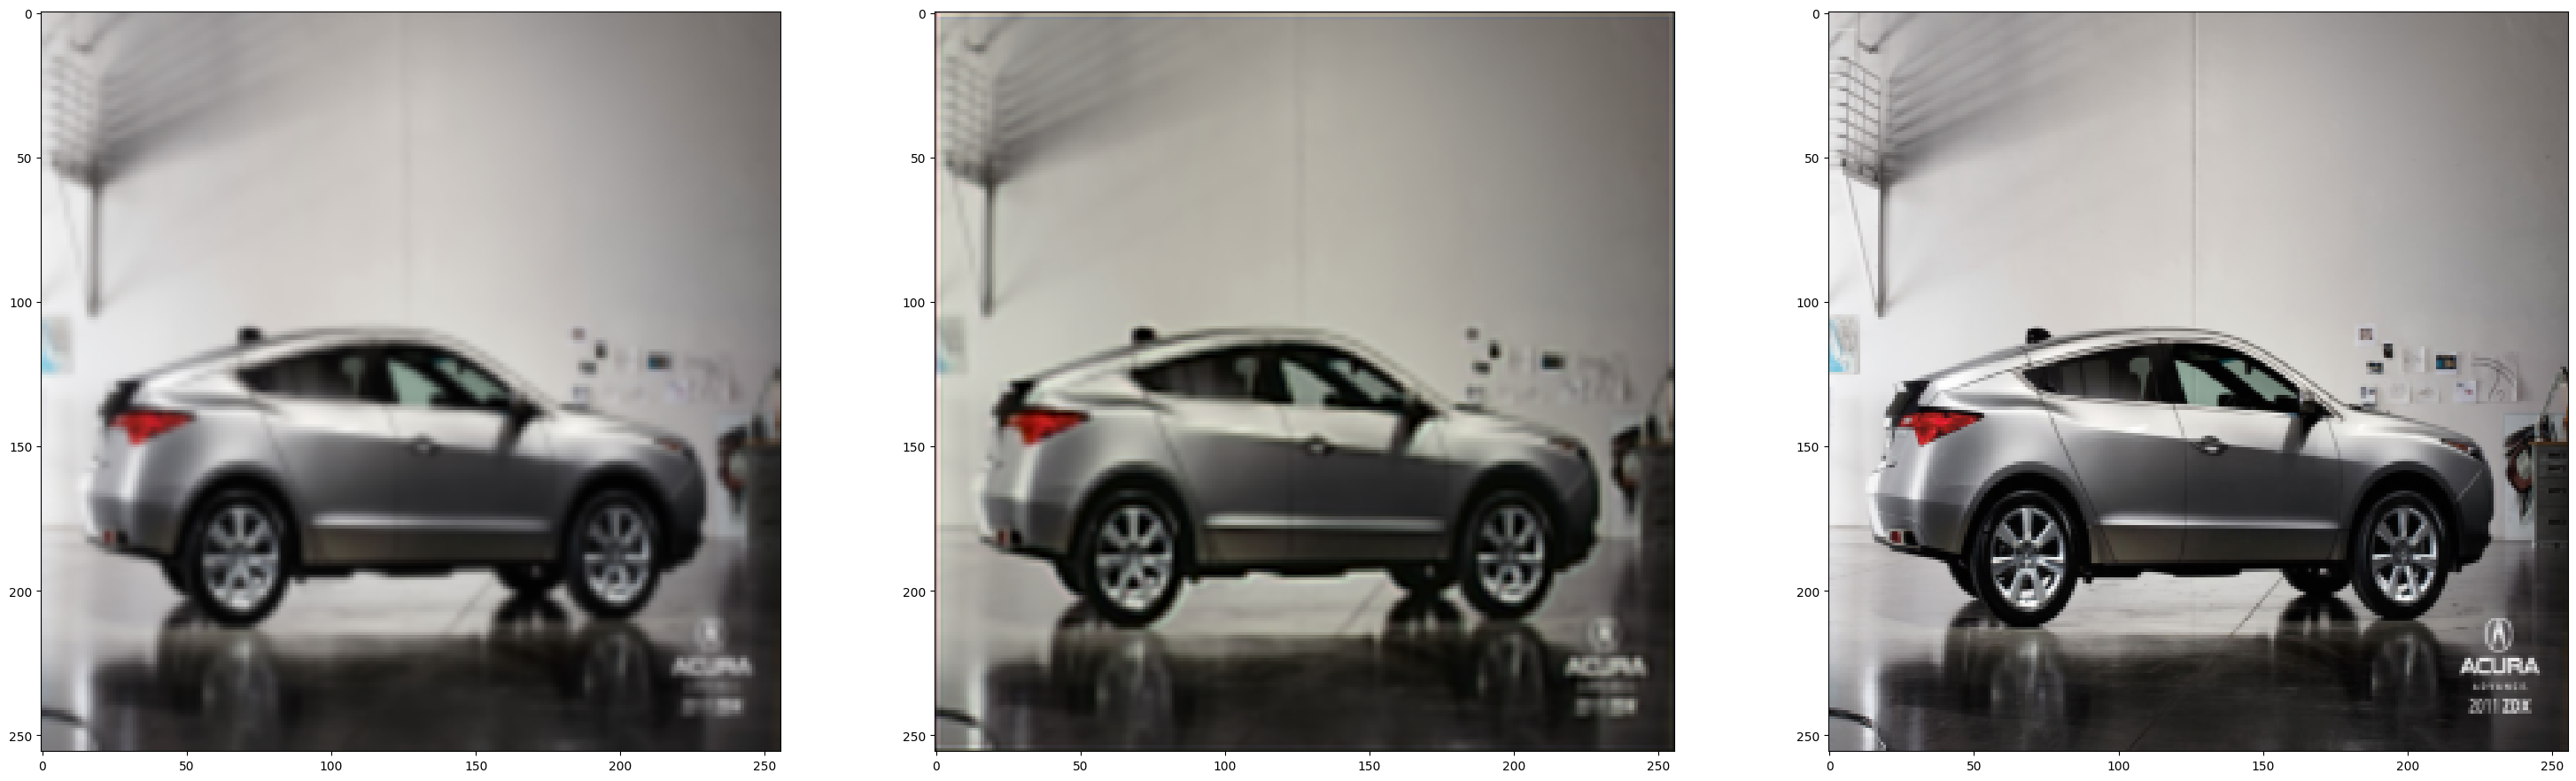

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])  #Input (low-res)
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])  # Output (supre-res recovered image)
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])  # Ground truth (high-res)
plt.show()


In [16]:
low_res = sr1[image_index]
high_res = x_train_n[image_index]

## Loss Metrics

Below are the most common metrics to measure the similarity between a pair of images.

### MSE

[Mean Squared Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) is a metric that indicates perfect similarity if the value is 0.

The value grows beyond 0 if the average difference between pixel intensities increases.

MSE has a few issues when used for similarity comparison, meaning that if you take an image and photoshop it to make it brighter and compare it with the original, the two images will be very different according to MSE as a dark image has pixel values closer to 0 and a bright image has pixel closer to 1, this means that the difference is going to be very big as MSE sees the image from a very general point of view.

Anyway, for our purpose, we compare lower quality images to their higher resolution counterpart, so the brightness is retained, this means that ** MSE is still a useful metric in our case**.

In [17]:
def mse(orig, res):
    return ((orig - res) ** 2).mean()

In [18]:
mse(high_res, low_res)

0.007652722014339849

### SSIM

[Structural similarity (SSIM)](https://en.wikipedia.org/wiki/Structural_similarity) measures the similarity between two images as would be perceived on a television or a similar media.

The SSIM is a value in the range $[1, -1]$ where $1$ would mean two indentical images, and lower values would show a "perceptual" difference.

This metric compares small windows in the image rather than the whole image (like MSE), which makes it a bit more interesting.

In [19]:
from skimage.metrics import structural_similarity as compare_ssim
import os
from matplotlib import pyplot

def ssim(ori, res):
    return compare_ssim(ori.astype(np.float64),
        res.astype(np.float64),
        gaussian_weights=True, data_range=1., win_size=1,
        sigma=1.5, multichannel=False, use_sample_covariance=False)

In [20]:
ssim(high_res, low_res)

<ipython-input-19-eeade4e550e3>:6: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  return compare_ssim(ori.astype(np.float64),
/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:348: RuntimeWarning: Images with dimensions (M, N, 3) are interpreted as 2D+RGB by default. Use `multichannel=False` to interpret as 3D image with last dimension of length 3.
  return func(*args, **kwargs)


0.8953893440321711

### PSNR

[Peak signal-to-noise ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio) is a metric defined using Mean Squared Error (seen above).

*PSNR is most commonly used to measure the quality of reconstruction of lossy compression* - Wikipedia

Low resolution and pixelization can be considered as a form of *compression* as we loose information.

When there's no noise, the PSNR is infinite (because there's a division by the MSE and MSE is $0$ when both images are exactly the same).

Of course, this means that we need to maximize the PSNR. The result is in decibel (dB).

In [21]:
from skimage.metrics import peak_signal_noise_ratio as compare_psnr

def psnr(ori, res):
    return compare_psnr(ori, res, data_range=1.)

In [22]:
psnr(high_res, low_res)

21.16184062161328

### HFENN

The HFENN (High Frequency Error Norm Normalized) metric gives  a  measure  of how high-frequency details differ between two images.

This means that we can guess if an image has more or less high frequency details (which are fine details that you need to zoom in to see and that are not blurry) compared to another image.

When the output value is 0 the images are identical. The greater the value, the more of a perceptual difference in both images there is.

In [23]:
import numpy as np
from scipy.ndimage import filters

def l_o_g(img, sigma):
    '''
    Laplacian of Gaussian filter (channel-wise)
    -> img: input image
    -> sigma: gaussian_laplace sigma
    <- filtered image
    '''
    while len(img.shape) < 3:
        img = img[..., np.newaxis]
    out = img.copy()
    for chan in range(img.shape[2]):
        out[..., chan] = filters.gaussian_laplace(img[..., chan], sigma)
    return out

def hfenn(orig, res):
    '''
    High Frequency Error Norm (Normalized) metric for comparison of original and result images
    The metric independent to image size (in contrast to regular HFEN)
    Inputs are expected to be float in range [0, 1] (with possible overflow)
    -> ori: original image
    -> res: result image
    <- HFENN value
    '''
    sgima = 1.5  # From DLMRI paper
    return np.mean((l_o_g(orig - res, sgima)) ** 2) * 1e4  # magnification

In [24]:
hfenn(high_res, low_res)

<ipython-input-23-737e749acc79>:15: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  out[..., chan] = filters.gaussian_laplace(img[..., chan], sigma)


0.3613180243560367

## Combining Loss Functions

Let's try using a loss that doesn't just tell us the pixel-wise difference in resolution, but that also if there's an improvement, for example, in high frequency details.

### MSE and HFENN

We can do a weight sum of both losses like:

$MSE + weight * HFENN$

We could choose $weight = 10$ and see what happens.

In [25]:
import scipy.ndimage as nd
import scipy.ndimage.filters as filters
from keras import losses
import tensorflow as tf

def hfenn_loss(ori, res):
    '''
    HFENN-based loss
    ori, res - batched images with 3 channels
    See metrics.hfenn
    '''
    fnorm = 0.325 # norm of l_o_g operator, estimated numerically
    sigma = 1.5 # parameter from HFEN metric
    truncate = 4 # default parameter from filters.gaussian_laplace
    wradius = int(truncate * sigma + 0.5)
    eye = np.zeros((2*wradius+1, 2*wradius+1), dtype=np.float32)
    eye[wradius, wradius] = 1.
    ker_mat = filters.gaussian_laplace(eye, sigma)
    with tf.name_scope('hfenn_loss'):
        chan = 3
        ker = tf.constant(np.tile(ker_mat[:, :, None, None], (1, 1, chan, 1)))
        filtered = tf.nn.depthwise_conv2d(ori - res, ker, [1, 1, 1, 1], 'VALID')
        loss = tf.reduce_mean(tf.square(filtered))
        loss = loss / (fnorm**2)
    return loss


def ae_loss(input_img, decoder):
    mse = losses.mean_squared_error(input_img, decoder) # MSE
    weight = 10.0 # weight
    return mse + weight * hfenn_loss(input_img, decoder) # MSE + weight * HFENN


Now, just compile the model with the new loss :

In [26]:
autoencoder_hfenn.compile(optimizer='adam', loss=ae_loss)

If you wanted to train the model, that's how you'd do :

In [ ]:
autoencoder_hfenn.fit(x_train_down, x_train_n,
                            epochs=10,
                            batch_size=10,
                            shuffle=True,
                            validation_split=0.15)

Epoch 1/10


/tmp/__autograph_generated_file22qs1aeb.py:21: DeprecationWarning: Please use `gaussian_laplace` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  ker_mat = ag__.converted_call(ag__.ld(filters).gaussian_laplace, (ag__.ld(eye), ag__.ld(sigma)), None, fscope)


22/22 [==============================] - 42s 991ms/step - loss: 0.0057 - val_loss: 0.0043
Epoch 2/10
22/22 [==============================] - 9s 426ms/step - loss: 0.0040 - val_loss: 0.0037
Epoch 3/10
22/22 [==============================] - 10s 439ms/step - loss: 0.0036 - val_loss: 0.0035
Epoch 4/10
22/22 [==============================] - 9s 426ms/step - loss: 0.0035 - val_loss: 0.0034
Epoch 5/10
22/22 [==============================] - 9s 425ms/step - loss: 0.0034 - val_loss: 0.0034
Epoch 6/10
22/22 [==============================] - 9s 423ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/10
22/22 [==============================] - 9s 420ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/10
22/22 [==============================] - 9s 419ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 9/10
22/22 [==============================] - 9s 419ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 10/10
22/22 [==============================] - 9s 420ms/step - loss: 0.0032 - val_loss: 0.0032


```Python
x_train_n = []
x_train_down = []
x_train_n, x_train_down = train_batches()
```

But, we'll just load the pretrained weights :

In [ ]:
# !unzip /content/weights.zip

In [ ]:
## TODO
## download the weights

# autoencoder_hfenn.load_weights("/content/weights/sr.img_net.mse_hfenn.final_model5_2.no_patch.weights.best.hdf5")

Let's see what the network can do after using our new custom loss :

In [ ]:
sr_hfenn = np.clip(autoencoder_hfenn.predict(x_train_down), 0.0, 1.0)

8/8 [==============================] - 2s 252ms/step


Display the image results:

* The low resolution input image
* A bicubic interopolated version
* The reconstructed image with MSE
* The reconstructed image with our custom MSE + HFENN loss
* The original perfect image




In [ ]:
image_index = 135

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(128, 128))
i = 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_hfenn[image_index])  # The reconstructed image with our custom MSE + HFENN loss
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index])
plt.show()

If you look a bit closely and check out the lines and edges, you'll se that they're sharper when using MSE and HFENN compared to MSE alone.

In [ ]:
plt.figure(figsize=(128, 128))
j = 6
i = 1
idx_1 = 32*j
idx_2 = 32*(j+1)
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index, idx_1:idx_2, idx_1:idx_2])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_down[image_index, idx_1:idx_2, idx_1:idx_2], interpolation="bicubic")
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr1[image_index, idx_1:idx_2, idx_1:idx_2])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(sr_hfenn[image_index, idx_1:idx_2, idx_1:idx_2])
i += 1
ax = plt.subplot(10, 10, i)
plt.imshow(x_train_n[image_index, idx_1:idx_2, idx_1:idx_2])
plt.show()

**Note** : double click on the images to make them bigger

In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.applications import VGG19
# from tensorflow.keras.models import Model
# from tensorflow.keras import losses

# # Load the pre-trained VGG19 model trained on ImageNet data
# vgg = VGG19(include_top=False, weights='imagenet', input_shape=(None, None, 3))

# # Choose the layer from which to extract features
# content_layers = ['block5_conv4']

# # Create a model that outputs the feature maps from the selected layers
# content_outputs = [vgg.get_layer(layer).output for layer in content_layers]
# feature_extractor = Model(vgg.input, content_outputs)

# # Define the perceptual loss function
# def perceptual_loss(y_true, y_pred):
#     # Extract features from both the target and generated images
#     target_features = feature_extractor(y_true)
#     generated_features = feature_extractor(y_pred)

#     # Compute the MSE between the features
#     loss = 0.0
#     for i in range(len(target_features)):
#         loss += tf.reduce_mean(tf.square(target_features[i] - generated_features[i]))

#     # Weight for the perceptual loss
#     weight = 0.1

#     return loss * weight

# # Assuming you have defined your autoencoder model somewhere in your code
# autoencoder_perceptual = Model(input_img, decoded)

# # Compile your autoencoder model with the perceptual loss
# autoencoder_perceptual.compile(optimizer='adam', loss=perceptual_loss)

# # Fit the model
# autoencoder_perceptual.fit(x_train_down, x_train_n,
#                            epochs=10,
#                            batch_size=10,
#                            shuffle=True,
#                            validation_split=0.15)

In [ ]:
sr_prec = np.clip(autoencoder_perceptual.predict(x_train_down), 0.0, 1.0)

In [ ]:
image_index = 135

In [ ]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(128, 128))
# i = 1
# ax = plt.subplot(10, 10, i)
# plt.imshow(x_train_down[image_index])
# i += 1
# ax = plt.subplot(10, 10, i)
# plt.imshow(sr1[image_index]) # The reconstructed image with our custom MSE loss
# i += 1
# ax = plt.subplot(10, 10, i)
# plt.imshow(sr_hfenn[image_index])  # The reconstructed image with our custom MSE + HFENN loss
# i += 1
# ax = plt.subplot(10, 10, i)
# plt.imshow(sr_prec[image_index])  # The reconstructed image with our custom perceptual loss
# i += 1
# ax = plt.subplot(10, 10, i)
# plt.imshow(x_train_n[image_index])
# plt.show()

In [ ]:
!pip install -q gradio


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
import gradio as gr
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow as tf

def predict(img):
    if not autoencoder_hfenn:  # Check if model is available
        return "Error: Model could not be loaded. Please check the logs for details."

    # Preprocess image for model input (if necessary)

    img = img_to_array(img)  # Convert Gradio input image to NumPy array
    img = tf.image.resize(img, (256, 256))  # Resize image
    img = img / 255.0  # Normalize to 0-1 range

    # Make prediction using the model

    predicted_img = autoencoder_hfenn.predict(tf.expand_dims(img, axis=0))[0]
    predicted_img = np.clip(predicted_img, 0.0, 1.0)  # Clip to 0-1 range
    return predicted_img

# Launch Gradio interface
interface = gr.Interface(fn=predict, inputs="image", outputs="image")
interface.launch(debug=True)


Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://e81dca2e4fdef5adaa.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


1/1 [==============================] - 0s 28ms/step


<ipython-input-45-e73285cd11ad>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  predicted_img_pil_resized = predicted_img_pil.resize((256, height_size), Image.ANTIALIAS)


1/1 [==============================] - 0s 19ms/step


<ipython-input-45-e73285cd11ad>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  predicted_img_pil_resized = predicted_img_pil.resize((256, height_size), Image.ANTIALIAS)


1/1 [==============================] - 0s 17ms/step


<ipython-input-45-e73285cd11ad>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  predicted_img_pil_resized = predicted_img_pil.resize((256, height_size), Image.ANTIALIAS)


1/1 [==============================] - 0s 26ms/step


<ipython-input-45-e73285cd11ad>:28: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  predicted_img_pil_resized = predicted_img_pil.resize((256, height_size), Image.ANTIALIAS)


In [ ]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.preprocessing.image import img_to_array
import gradio as gr

In [ ]:
def single_predict(img_path):
    if not autoencoder_hfenn:  # Check if model is available
      return "Error: Model could not be loaded. Please check the logs for details."

    # Load the image
    img = Image.open(img_path)
    img = img.convert("RGB")  # Ensure the image is in RGB format
    img = img.resize((256, 256))  # Resize image
    img = img_to_array(img) / 255.0  # Convert image to NumPy array and normalize

    # Make prediction using the model
    predicted_img = autoencoder_hfenn.predict(tf.expand_dims(img, axis=0))[0]
    predicted_img = np.clip(predicted_img, 0.0, 1.0)  # Clip to 0-1 range

    # Convert predicted image array to PIL Image
    predicted_img_pil = Image.fromarray((predicted_img * 255).astype(np.uint8))

    return predicted_img_pil

In [ ]:
image_path = "/content/download.jpg"
pred_img = single_predict(image_path)
pred_img.save("predicted_image.jpg")